# `BootstrapImages Notebook`
This file is for pasting game character crops onto game backgrounds. The current implementation
either places objects randomly around the background or normally distributed around a central point.
Objects are placed in fully visible areas, and object occlusion is not taken into account <br>
 ### `Planned Improvements`
- Foreground object-crop placement like minimap, health
- Random noise. Can be added before training, or right after generation
- Account for occluded objects using IoU. 
- After object detection,animation classification! 

In [42]:
COLAB = False

# Extract cropped images from google drive

In [43]:
import zipfile
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

In [44]:
if COLAB:
    zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Short_Term_Project/DataGeneration/lol_cropped_images/monsters_cropped.zip", 'r')
    zip_ref.extractall("/content/drive/MyDrive/Short_Term_Project/DataGeneration/lol_cropped_images/monsters_cropped")
    zip_ref.close()

# Bootstrap images

In [45]:
import numpy as np
from PIL import ImageDraw, ImageFont, ImageFilter, Image
#import PIL.Image
from PIL import ImageFilter
from shapely.geometry import Polygon
import random
import os
from os import listdir, path
#from IPython.display import Image 
from tqdm.notebook import tqdm

In [46]:
OUTPUT_SIZE = 10000
AUGMENT_DATASET = True
centre_padding = 400 # 400 is good
centre_stdev_min_max = [300, 400] # stdev x y should be less than centre padding so that coordinates are within backgnd! negative coordinates map to zero in image lib
random_padding = [200, 200]
rotate_min_max = [-5,5]
cropped_img_size_offset = [-5, -5]
alpha_chan_delta_min_max = [-100, -1]
noise_delta = 20
p_noise_min_max = [0, 0.3]
box_blur_rad_min_max = [0, 2]
HB_CLASS_RCREEP, HB_CLASS_BCREEP, HB_CLASS_RCHAMP, HB_CLASS_BCHAMP, HB_CLASS_RTOWER, HB_CLASS_BTOWER, HB_CLASS_MONSTER = 0, 1, 2, 3, 4, 5, 6
# Probabilities of adding objects
P_ADD_TOWER = 0.8
P_ADD_MONSTER = 1.0
P_ADD_HEALTH_BAR = 1.0
P_ADD_FLAG = 0.3
P_BLANK_IMAGE = 0.2

In [47]:
# Global variables
scales = {'tower' : [0.6, 0.9],
         'creep'  : [0.9, 1.2], 
         'champ'  : [2.0, 3.0],
          'monst' : [1.8 , 2.0]
         }
            # Red structures
classes = { 'rtower' :0,
            'rinhib' :0,
            'rnexus' :0, 
           
            'btower' :1,
            'binhib' :1,
            'bnexus' :1,
           
            'rmelee' :2,
            'rranged':2,
            'rseiged':2,
            'rsuper' :2,
           
            'bmelee' :3,
            'branged':3,
            'bseiged':3,
            'bsuper' :3,
           
            'champ_Rumble' :4,
            'champ_Sylas'  :5, 
            'champ_Viego'  :6,
            'champ_Rakan'  :7,
            'champ_Zeri'   :8,
            'champ_Darius' :9,
            'champ_Graves' :10,
            'champ_Ryze'   :11,
            'champ_Karma'  :12,
            'champ_Veigar' :13,
           
           'monst_baron'   :14,
           'monst_dragon'  :15,
           'monst_herald'  :16,
           'monst_raz_beak':17,
           'monst_krug'    :18,
           'monst_wolf'    :19,
           'monst_gromp'   :20
          }
creeps_min_max = [2, 10]
champs_num = 10
monst_num = 7
champs_min_max = [4, champs_num]
monst_min_max = [2, monst_num//2]

#n_classes = 20 + 1

# Input paths
if COLAB:
    input_path_prefix   = '/content/drive/MyDrive/Short_Term_Project/DataGeneration/lol_cropped_images/'
    # Output paths
    output_path_prefix = '/content/drive/MyDrive/Short_Term_Project/synth_dataset_aug_v0/'
    path_prefix_artifacts = '/content/drive/MyDrive/Short_Term_Project/DataGeneration/game_artifacts/'

else:
    input_path_prefix = 'v2_crops/'
    output_path_prefix = input_path_prefix + 'v2_01_syn_dataset_augs/'
    # output_path_prefix = 'D:/SK MSc/II/data/'
    
#input_path_prefix = ''
path_bckgnds  = input_path_prefix + 'map_screenshots/'
path_creep    = input_path_prefix + 'creeps_cropped/'
path_rtowers  = input_path_prefix + 'towers_cropped/red/'
path_btowers  = input_path_prefix + 'towers_cropped/blue/'

# MONSTERS
path_monsters  = input_path_prefix + 'v2_1_monsters_cropped/'
path_baron     = path_monsters + 'Summoners Rift Baron'  
path_dragon    = path_monsters + 'Summoners Rift Dragon Fire'
path_herald    = path_monsters + 'Summoners Rift Herald'
path_razor_beak= path_monsters + 'Summoners Rift Razor Beak'
path_krug      = path_monsters + 'Summoners Rift Krug'
path_wolf      = path_monsters + 'Summoners Rift Murk Wolf'
path_gromp     = path_monsters + 'Summoners Rift Gromp'

# CHAMPIONS
# path_garen    = input_path_prefix + 'Champions_cropped/champions/Garen/'
# path_nasus    = input_path_prefix + 'Champions_cropped/champions/Nasus/'
# path_morgana  = input_path_prefix + 'Champions_cropped/champions/Morgana/'
path_champs  = input_path_prefix + 'v2_01_champs_cropped/'
path_Rumble  = path_champs + 'Rumble'
path_Sylas   = path_champs + 'Sylas' 
path_Viego   = path_champs + 'Viego' 
path_Rakan   = path_champs + 'Rakan' 
path_Zeri    = path_champs + 'Zeri'  
path_Darius  = path_champs + 'Darius'
path_Graves  = path_champs + 'Graves'
path_Ryze    = path_champs + 'Ryze'  
path_Karma   = path_champs + 'Karma' 
path_Veigar  = path_champs + 'Veigar'

path_prefix_artifacts = input_path_prefix + 'game_artifacts/'
path_blast_cones  = path_prefix_artifacts + 'blast_cones/'
path_fireballs    = path_prefix_artifacts + 'fireballs/'
path_flags        = path_prefix_artifacts + 'flags'
path_grass        = path_prefix_artifacts + 'grass'

# Health bars according to class
path_health_bars  = path_prefix_artifacts + 'HealthBars/'
path_RCreeps_HB   = path_health_bars + 'RedMinion'
path_BCreeps_HB   = path_health_bars + 'BlueMinion'
path_BChamp_HB   = path_health_bars + 'BlueChampion'
path_RChamp_HB   = path_health_bars + 'RedChampion'
path_RTower_HB   = path_health_bars + 'RedTower'
path_BTower_HB   = path_health_bars + 'BlueTower'
path_Monster_HB   = path_health_bars + 'Monster'

path_misc_art     = path_prefix_artifacts + 'misc_art'

#output_path_prefix = 'synth_dataset_aug_v0/'
path_output_imgs    = output_path_prefix + 'imgs/'
path_output_labels  = output_path_prefix + 'imgs/'
path_output_labels_hb_and_crop = output_path_prefix + 'lbls_hb_and_crop/'
path_output_labels_hb_class    =   output_path_prefix + 'lbls_hb_classes/'
save_prefix = 'lol_'

In [48]:
# Helper functions
# Scans a dir for all files containint 'filt'
def get_files_in_dir_as_dict(path, filt='.csv'):
    ''' Get all files from path. Returns a dict of folder + path'''
    assert os.path.exists(path), "The path {} was not found!".format(path)
    f = dict()
    for (dirpath, dirnames, filenames) in os.walk(path):
        files = [os.path.join(dirpath,f) for f in filenames if filt in f]
        if len(files) > 0:
            f[dirpath] = files
    return f
def get_files_in_dir_as_list(path, filt='.csv'):
    ''' Wrapper for the function above. Gets all files in a directory as a list'''
    f_dict = get_files_in_dir_as_dict(path, filt)
    return [k for key in f_dict for k in f_dict[key]]
def calc_oclusion(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    occl_A_by_B = 1 - (boxAArea - interArea)/boxAArea
    occl_B_by_A = 1 - (boxBArea - interArea )/boxBArea
    return  occl_A_by_B, occl_B_by_A

In [49]:
# DATA AUGUMENTATION FUNCTIONS
def apply_noise_pixel(pixel, noise=(10,10,10)):
    """
    This funciton applies random noise to the rgb values of a pixel (R,G,B)
    """
    R = max(0, min(255, pixel[0] + random.randint(noise[0], noise[0])))
    G = max(0, min(255, pixel[1] + random.randint(noise[1], noise[1])))
    B = max(0, min(255, pixel[2] + random.randint(noise[2], noise[2])))
    A = pixel[3]
    return (R, G, B, A)

def apply_noise_img(img, noise=(10,10,10), p_noise=0.5):
    ''' Applies noise to image pixels of portion size x'''
    w, h = img.size
    img_data = list(img.getdata())
    len_data = len(img_data)
    idxs = random.sample(range(len_data), k=int(p_noise*len_data))
    for x in idxs:
        img_data[x] = apply_noise_pixel(img_data[x], noise)
    img.putdata(img_data)        
    return img

def change_img_alpha_channel(img, alpha_delta=-20, thres = 20):
    img_data = list(img.getdata())
    len_data = len(img_data)
    for x in range(len_data):
        if(img_data[x][3] > thres):
            img_data[x] = *img_data[x][:3], img_data[x][3]+alpha_delta
    ret = img.copy()
    ret.putdata(img_data)        
    return ret.convert('RGBA') 

def random_rescale(og_size, min_max_scale):
    """
    Rescale size according to random scale factor depending on image class
    """
    #scale_min, scale_max = min_max_scale
    #print(og_size, min_max_scale)
    scale_factor = random.uniform(*min_max_scale)
    return int(og_size[0]*scale_factor), int(og_size[1]*scale_factor)

In [50]:
def get_obj_scale_factor(obj_file_name):
        if('creep' in obj_file_name):
            return scales['creep']
        if('tower' in obj_file_name):
            return scales['tower']
        if('champ' in obj_file_name):
            return scales['champ']
        if('monst' in obj_file_name):
            return scales['monst']
        
def get_obj_corners(pos, obj_size, bckgrnd_size=(1920, 1080)):
    w, h = obj_size
    bw, bh = bckgrnd_size
    min_x = int(max(pos[0], 0))
    min_y = int(max(pos[1], 0))
    min_x = min(min_x, bckgrnd_size[0] - obj_size[0])
    min_y = min(min_y, bckgrnd_size[1] - obj_size[1])
    max_x = min_x + obj_size[0]
    max_y = min_y + obj_size[1]
    return min_x, min_y, max_x, max_y 

def get_obj_center_pos(pos, size):
    return int(pos[0] + size[0]/2), int(pos[1] + size[1]/2)

def create_yolo_label_str(cpos, size, img_class, bckgnd_size = (1920, 1080)): 
    return "{} {} {} {} {}\n".format(img_class, cpos[0]/bckgnd_size[0],cpos[1]/bckgnd_size[1], 
                                   size[0]/bckgnd_size[0], size[1]/bckgnd_size[1])

def get_box(pos, size):
    box = [[pos[0],           pos[1]          ], # top-left
           [pos[0] + size[0], pos[1]          ],
           [pos[0] + size[0], pos[1] + size[1]],
           [pos[0],           pos[1] + size[1]]
          ]
    return box

def calculate_iou(pos1, size1, pos2, size2):
    '''
    Calculate IoU in oder to get percentage of occlusion of 1 image by another.
    If occlued by > 0.80%, discard
    '''
    poly_1 = Polygon(get_box(pos1, size1))
    poly_2 = Polygon(get_box(pos2, size2))
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou
        
def draw_bound_box(curr_bckgnd, x1,y1,x2,y2,obj_cpos,ob_name, curr_objects_ls):
    box = ImageDraw.Draw(curr_bckgnd) 
    box.rectangle([(x1,y1), (x2,y2)], outline="red")
    box.text((obj_cpos[0]-11, obj_cpos[1]-22), text='+', fill='red', font=ImageFont.truetype("arial.ttf", 40), )
    box.text((x1-11, y1-22), text='+', fill='green', font=ImageFont.truetype("arial.ttf", 40))
    #box.text((obj_cpos[0], y1), text='+', fill='green', font=ImageFont.truetype("arial.ttf", 40))
    #box.text((x1, obj_cpos[1]), text='+', fill='green', font=ImageFont.truetype("arial.ttf", 40))
    ob_name = path.basename(curr_objects_ls[i][0])
    box.text((x1, y1), text='{}\n{}'.format(ob_name, obj_cpos), stroke_fill='red', font=ImageFont.truetype("arial.ttf", 15))


In [51]:
# Get creeps images
f_rcreeps = get_files_in_dir_as_list(path_creep,  'Chaos')
f_rcreeps = [x for x in f_rcreeps if 'eath' not in x] # Filter death animation. Affects boundimg box size
f_bcreeps = get_files_in_dir_as_list(path_creep,  'Order')
f_bcreeps = [x for x in f_bcreeps if 'eath' not in x]
# f_monsters = get_files_in_dir_as_list(path_monsters, 'png')

# Get monters images
f_baron     = get_files_in_dir_as_list(path_baron     , 'png')
f_dragon    = get_files_in_dir_as_list(path_dragon    , 'png')
f_herald    = get_files_in_dir_as_list(path_herald    , 'png')
f_razor_beak= get_files_in_dir_as_list(path_razor_beak, 'png')
f_krug      = get_files_in_dir_as_list(path_krug      , 'png')
f_wolf      = get_files_in_dir_as_list(path_wolf      , 'png')
f_gromp     = get_files_in_dir_as_list(path_gromp     , 'png')

# f_morgana = get_files_in_dir_as_list(path_morgana,'png')
# f_nasus   = get_files_in_dir_as_list(path_nasus, 'png')
# f_garen   = get_files_in_dir_as_list(path_garen, 'png')
f_Rumble = get_files_in_dir_as_list(path_Rumble ,'png')
f_Sylas  = get_files_in_dir_as_list(path_Sylas , 'png')
f_Viego  = get_files_in_dir_as_list(path_Viego , 'png')
f_Rakan  = get_files_in_dir_as_list(path_Rakan , 'png')
f_Zeri   = get_files_in_dir_as_list(path_Zeri  , 'png')
f_Darius = get_files_in_dir_as_list(path_Darius, 'png')
f_Graves = get_files_in_dir_as_list(path_Graves, 'png')
f_Ryze   = get_files_in_dir_as_list(path_Ryze  , 'png')
f_Karma  = get_files_in_dir_as_list(path_Karma , 'png')
f_Veigar = get_files_in_dir_as_list(path_Veigar, 'png')

f_rtowers = get_files_in_dir_as_list(path_rtowers, 'png')
f_btowers = get_files_in_dir_as_list(path_btowers, 'png')
f_bckgnds   = get_files_in_dir_as_list(path_bckgnds, 'png')

f_flags = get_files_in_dir_as_list(path_flags, 'png')

f_RCreeps_HB = get_files_in_dir_as_list(path_RCreeps_HB, 'png')
f_BCreeps_HB = get_files_in_dir_as_list(path_BCreeps_HB, 'png')
f_BChamp_HB  = get_files_in_dir_as_list(path_BChamp_HB , 'png')
f_RChamp_HB  = get_files_in_dir_as_list(path_RChamp_HB , 'png')
f_RTower_HB  = get_files_in_dir_as_list(path_RTower_HB , 'png')
f_BTower_HB  = get_files_in_dir_as_list(path_BTower_HB , 'png')
f_Monster_HB = get_files_in_dir_as_list(path_Monster_HB, 'png')

f_grass = get_files_in_dir_as_list(path_grass, 'png')

# Add images to array by class name
objects = dict()
objects[classes['rtower']] = f_rtowers
objects[classes['rmelee']] = f_rcreeps
objects[classes['btower']] = f_btowers
objects[classes['bmelee']] = f_bcreeps

# Monsters
objects[classes['monst_baron' ]] = f_baron     
objects[classes['monst_dragon']] = f_dragon    
objects[classes['monst_herald']] = f_herald    
objects[classes['monst_raz_beak']] =f_razor_beak
objects[classes['monst_krug']] = f_krug      
objects[classes['monst_wolf']] = f_wolf      
objects[classes['monst_gromp']] = f_gromp     

    
# objects[classes['champ_nasus']] = f_nasus
# objects[classes['champ_garen']] = f_garen
# objects[classes['champ_morgana']] = f_morgana
objects[classes['champ_Rumble']] = f_Rumble
objects[classes['champ_Sylas' ]] = f_Sylas 
objects[classes['champ_Viego' ]] = f_Viego 
objects[classes['champ_Rakan' ]] = f_Rakan 
objects[classes['champ_Zeri'  ]] = f_Zeri  
objects[classes['champ_Darius']] = f_Darius
objects[classes['champ_Graves']] = f_Graves
objects[classes['champ_Ryze'  ]] = f_Ryze  
objects[classes['champ_Karma' ]] = f_Karma 
objects[classes['champ_Veigar']]  = f_Veigar

# Champs
champs = [champ for champ in classes if 'champ' in champ]

# Monsters 
monsters  = [monst for monst in classes if 'monst' in monst]

In [52]:
def get_health_bar(obj_file_name):

    if('Order' in obj_file_name):
        hb = random.choice(f_BCreeps_HB)
        hb_class = HB_CLASS_BCREEP
        
    elif('Chaos' in obj_file_name):
        hb = random.choice(f_RCreeps_HB)
        hb_class = HB_CLASS_RCREEP
        
    elif('champ' in obj_file_name):
        if random.random() < 0.5:
            hb = random.choice(f_BChamp_HB)
            hb_class = HB_CLASS_BCHAMP
        else:
            hb = random.choice(f_RChamp_HB)
            hb_class = HB_CLASS_RCHAMP
            
    elif('monsters' in obj_file_name):
        hb = random.choice(f_Monster_HB)
        hb_class = HB_CLASS_MONSTER
        
    elif('towers_cropped/red' in obj_file_name):
        hb = random.choice(f_RTower_HB)
        hb_class = HB_CLASS_RTOWER
        
    elif('towers_cropped/blue' in obj_file_name):
        hb = random.choice(f_BTower_HB)
        hb_class = HB_CLASS_BTOWER
    
    return hb, hb_class 

In [53]:
os.makedirs(path_output_imgs,exist_ok=True)
os.makedirs(path_output_labels, exist_ok=True)

os.makedirs(path_output_labels_hb_and_crop, exist_ok=True)
os.makedirs(path_output_labels_hb_class,   exist_ok=True)

In [54]:
def get_rcreeps():
    return random.sample(f_rcreeps, k=random.randint(creeps_min_max[0], creeps_min_max[1]))

def get_bcreeps():
    return random.sample(f_bcreeps, k=random.randint(creeps_min_max[0], creeps_min_max[1]))
        

In [55]:
PATH_IDX, CLASS_IDX, POS_IDX,  CPOS_IDX, SIZE_IDX = 0,1,2,3,4
# Ok, I'm in a hurry, So i'm going to do this real - quick and messy. Don't judge me!
# output_df = open(input_path_prefix + 'outputdf.csv', 'w+')
# output_df.write('file_name, class, pos, bbox, cent_random, cent_stdev, a_chan_delta, src_crop,')
for img_num in tqdm(range(OUTPUT_SIZE)):
    
    # CREEPS: Get a random number of creeps between the min and max values
    curr_objects = dict()
    #rcreeps = random.choices(f_rcreeps, k=random.randint(creeps_min_max[0], creeps_min_max[1]))
    #bcreeps = random.choices(f_bcreeps, k=random.randint(creeps_min_max[0], creeps_min_max[1]))
    curr_objects[classes['rmelee']] = get_rcreeps()
    curr_objects[classes['bmelee']] = get_bcreeps()
    
    # MONSTER: Add a monster to the image, with low probability
    # if(random.random() < P_ADD_MONSTER):
    #     monst = random.choice(f_monsters)
    #     curr_objects[classes['monsters']] = [monst]
        
    # TOWERS: Always one tower in an image. Randomly chose between red and blue, p=0.5
    if(random.random() < P_ADD_TOWER):
        if(random.random() < 0.5):
            tower = random.choice(f_rtowers)
            curr_objects[classes['rtower']] = [tower]
        else:
            tower = random.choice(f_btowers)
            curr_objects[classes['btower']] = [tower]
    # MONSTERS: Select monster  names randomly
    monst_names = random.sample(monsters, k=random.randint(monst_min_max[0], monst_min_max[1]))
    for monst in monst_names:
        file = random.choice(objects[classes[monst]])
        # curr_champs.append(file)
        curr_objects[classes[monst]] = [file]
        
    # CHAMPION: Select champion names randomly
    champ_names = random.sample(champs, k=random.randint(champs_min_max[0], champs_min_max[1]))
    
    # Select champ images randomly from file names. 
    for champ in champ_names:
        file = random.choice(objects[classes[champ]])
        # curr_champs.append(file)
        curr_objects[classes[champ]] = [file]
    
    # TODO: Add some random objects
    
    # Dict to list of (filename,class, [posx, posy], [cposx, cposy], [w, h])
    curr_objects_ls = [(val, ob_class, [int, int], [int, int],  [int, int])  
                       for ob_class in curr_objects 
                       for val in curr_objects[ob_class]]
    
    # shuffle the obects order. Canges the order with wi=hich objects are pasted
    random.shuffle(curr_objects_ls)
    
    # Get background
    curr_bckgnd =  Image.open(random.choice(f_bckgnds))
    bck_w, bck_h = curr_bckgnd.size
    # Make sure the image is 1920x1080
    assert (bck_w == 1920 and bck_h == 1080), "Error! Background image is {}x{}. It has to be 1920x1080".format(bck_w, bck_h) 

    # Randomly choose between random and normally distributed placement of images around central point
    # Get random central corrdinate. All images will be clustered around central corrdinate
    central_pos = (random.randint(centre_padding, bck_w-1-centre_padding), 
                   random.randint(centre_padding, bck_h-1-centre_padding))
    
    # Get stdev for placing images around central point
    stdev = random.randint(*centre_stdev_min_max)
    # print(f'Central pos = {central_pos}, stdev = {stdev}')
    yolo_labels = ''
    yolo_labels_with_hbar = ''
    
    curr_img_obj_locs = []
    health_bars = []
    if(random.random() > P_BLANK_IMAGE):
        # Place towers at the beginning of the list
        for i, obj in zip(range(len(curr_objects_ls)), curr_objects_ls):
            if (obj[CLASS_IDX] == classes['btower'] or
                obj[CLASS_IDX] == classes['rtower'] ):
                # remove tower from list
                curr_objects_ls.remove(obj)
                curr_objects_ls.insert(0, obj)
            elif obj[CLASS_IDX] >= classes['monst_baron']:
                # remove tower from list
                curr_objects_ls.remove(obj)
                curr_objects_ls.insert(1, obj)
                
        for i, obj in zip(range(len(curr_objects_ls)), curr_objects_ls):
            if(random.random() < 0.7) and (obj[CLASS_IDX] == classes['rmelee'] or
                obj[CLASS_IDX] == classes['bmelee']):
                x1 = int(np.random.normal(loc=central_pos[0], scale=stdev))
                y1 = int(np.random.normal(loc=central_pos[1], scale=stdev))
            else:
                # get a random pos on the map
                x1 = np.random.randint(0, bck_w-random_padding[0])
                y1 = np.random.randint(0, bck_h-random_padding[1])
                
            # Get the actual image
            curr_im = Image.open(curr_objects_ls[i][PATH_IDX]).convert("RGBA")
            
            if AUGMENT_DATASET:
                ## IMAGE AUGUMENTATION
                # 1.  Change alpha channel of object
                a_chan_dev = random.randint(*alpha_chan_delta_min_max)
                curr_im = change_img_alpha_channel(curr_im, alpha_delta=a_chan_dev) 
            
                # 2.  Add random noise to parts of image
                p_noise = random.uniform(*p_noise_min_max)
                curr_im = apply_noise_img(curr_im, noise=(noise_delta,noise_delta,noise_delta), p_noise=p_noise)
            
                # 3. Random rotate
                rot_val = random.randint(*rotate_min_max)
                curr_im = curr_im.rotate(rot_val, expand=1) # expand = 1 to change image size  
            
                # 4.Rescale image 
                # Add size to data array. w, h are index 3
                scale_factor = get_obj_scale_factor(curr_objects_ls[i][PATH_IDX])
                rescaled_size = random_rescale(curr_im.size, scale_factor)
                curr_im = curr_im.resize(rescaled_size)
        
                #rescaled_size = rescaled_size[0] + cropped_img_size_offset[0],  rescaled_size[1] + cropped_img_size_offset[1]
                x1, y1, x2, y2 = get_obj_corners((x1, y1), rescaled_size) # Object may fall out of background image! Hence get actual corners in image
                rescaled_size = abs(x1 - x2), abs(y1- y2)
            else:
                rescaled_size = curr_im.size
                x1, y1, x2, y2 = get_obj_corners((x1, y1), rescaled_size)
                rescaled_size = abs(x1 - x2), abs(y1- y2)
                
            # Cropped image size is larger than actual object. 
            # Reduce bounding box size by inc xmin, ymin and reducing xmax, ymax by a percentage of img size
            bbox_pcnt = 0.1
            x_redxn = int(rescaled_size[0]*bbox_pcnt)
            y_redxn = int(rescaled_size[1]*bbox_pcnt)
            x1_bbox, y1_bbox, x2_bbox, y2_bbox = x1 + x_redxn, y1 + y_redxn, x2 - x_redxn, y2 - y_redxn
            size_bbox = abs(x1_bbox - x2_bbox), abs(y1_bbox- y2_bbox)
            # Get object center position, add to array index 3
            obj_cpos = get_obj_center_pos((x1, y1), rescaled_size)
            
            # CHECK FOR OCCLUSION OF OTHER OBJECTS. SKIP IF OCCLUSION > 80%
            occl = False
            # calclate occlution before pasting
            bboxB = x1, y1, x1 + curr_im.size[0], y1 + curr_im.size[1]
            for loc, size in curr_img_obj_locs:
                bboxA = (loc[0], loc[1], loc[0] + size[0], loc[1] + size[1])
                occA_by_B, _ = calc_oclusion(bboxA, bboxB)
                if occA_by_B > 0.80:
                    print(f'{obj[CLASS_IDX]}, {occA_by_B}, A = {bboxA}, B= {bboxB}' )    
                    occl = True
                    break
            if occl:
                continue
                
            # Add the obj data to array
            curr_obj_class = curr_objects_ls[i][CLASS_IDX]
            curr_objects_ls[i][POS_IDX] [0] = x1_bbox
            curr_objects_ls[i][POS_IDX] [1] = y1_bbox
            curr_objects_ls[i][SIZE_IDX][0] = size_bbox[0]
            curr_objects_ls[i][SIZE_IDX][1] = size_bbox[1]
            curr_objects_ls[i][CPOS_IDX][0] = obj_cpos[0]
            curr_objects_ls[i][CPOS_IDX][1] = obj_cpos[1]
           # output_df()
            # TODO: Add some grass on top of the image
            
            # Add health-bar overlay on top of the crop
            if True:
                hb_file_path, hb_class = get_health_bar(curr_objects_ls[i][PATH_IDX])
                curr_hbar = Image.open(hb_file_path).convert('RGBA')
                #print(hb_file_path, "===>",curr_objects_ls[i][PATH_IDX] )
                resize_factor = curr_im.size[0]/curr_hbar.size[0]
                resize_factor = (random.randint(7, 10)/10) * resize_factor
                new_bar_size = np.array(resize_factor*np.array(curr_hbar.size), np.int)
                new_bar = curr_hbar.resize(new_bar_size)
                w_diff = curr_im.size[0] - new_bar_size[0]
                # curr_im.paste(new_bar, (w_diff//2, 0), new_bar)
                y_shift_hb = new_bar.size[1]//2
                health_bars.append((hb_class, new_bar, (x1+w_diff//2, y1-y_shift_hb), new_bar.size))
            # Paste image to background
  
            curr_bckgnd.paste(curr_im, box=(x1, y1), mask=curr_im)
            curr_img_obj_locs.append(((x1, y1), curr_im.size))
                
            # Create yolo label
            yolo_labels += create_yolo_label_str(obj_cpos, size_bbox, curr_obj_class, (bck_w, bck_h))
            yolo_labels_with_hbar += create_yolo_label_str((obj_cpos[0], obj_cpos[1]-y_shift_hb/2),
                                                           size_bbox, 
                                                           curr_obj_class, 
                                                           (bck_w, bck_h))
                                                          
                #yolo_labels_bbox +=
            # Debugging. Draw box around image
            # ob_name = str(curr_obj_class)
            # draw_bound_box(curr_bckgnd,x1_bbox, y1_bbox, x2_bbox, y2_bbox, obj_cpos, ob_name, curr_objects_ls)
        #display(curr_bckgnd)
        
        # TODO: Add various random artefacts onto the image
        # Add flag item
    #if(random.random() < P_ADD_FLAG):   
    #  curr_flag = PIL.Image.open(random.choice(f_flags)).convert('RGBA')
    #  curr_flag = curr_flag.resize(random_rescale(curr_flag.size, [0.7, 1.4]))
    #  curr_flag = curr_flag.rotate(angle=random.randint(0, 45), expand=1)
    #  curr_bckgnd.paste(curr_flag, 
    #                    box=(np.random.randint(0, bck_w-random_padding[0]),
    #                         np.random.randint(0, bck_h-random_padding[1])), 
    #                         mask=curr_flag)
    
    # Add health bars on top of all images
    yolo_labels_h_bar = ''
    for hb_class, hb, pos, hb_size in health_bars:
        curr_bckgnd.paste(hb, box=pos, mask=hb)
        cpos=get_obj_center_pos(pos, hb_size)
        yolo_labels_h_bar += create_yolo_label_str(cpos, hb_size, hb_class)
    # Blur the image
    if AUGMENT_DATASET:
        curr_bckgnd = curr_bckgnd.filter(ImageFilter.BoxBlur(random.randint(*box_blur_rad_min_max)))
    
    # Save image 
    save_name = path_output_imgs + save_prefix + str(img_num) +'.jpg'
    save_lbl = path_output_labels + save_prefix + str(img_num) +'.txt'
    
    save_lbl_hb_and_crop = path_output_labels_hb_and_crop + save_prefix + str(img_num) +'.txt'
    save_lbl_hb_class    = path_output_labels_hb_class  + save_prefix + str(img_num) +'.txt'
    
    with open(save_lbl, 'w+') as f:
        f.write(yolo_labels)
        
    with open(save_lbl_hb_and_crop, 'w+') as f:
        f.write(yolo_labels_with_hbar)
        
    with open(save_lbl_hb_class, 'w+') as f:
        f.write(yolo_labels_h_bar)
        
    curr_bckgnd.save(save_name)

9, 0.8473282442748091, A = (1332, 508, 1456, 638), B= (1280, 528, 1621, 819)
7, 0.8926174496644296, A = (1439, 306, 1587, 418), B= (1343, 158, 1571, 453)
6, 1.0, A = (1269, 868, 1406, 971), B= (1261, 687, 1610, 1058)
5, 1.0, A = (633, 576, 742, 700), B= (543, 479, 944, 775)
4, 1.0, A = (1181, 444, 1259, 522), B= (1099, 431, 1306, 612)
2, 0.806640168342296, A = (643, 433, 733, 526), B= (659, 435, 745, 534)
14, 1.0, A = (1288, 275, 1371, 471), B= (954, 263, 1557, 1080)
12, 0.8848920863309353, A = (1581, 267, 1719, 387), B= (1513, 232, 1703, 504)
9, 0.8439024390243902, A = (1636, 273, 1840, 522), B= (1668, 186, 1920, 553)
4, 1.0, A = (1494, 741, 1606, 826), B= (1450, 704, 1668, 945)
4, 1.0, A = (1145, 180, 1259, 279), B= (1107, 160, 1560, 404)
6, 1.0, A = (776, 565, 885, 647), B= (532, 225, 936, 656)
4, 1.0, A = (1640, 368, 1777, 454), B= (1492, 155, 1920, 473)
6, 0.8503937007874016, A = (826, 450, 971, 576), B= (808, 469, 1254, 938)
14, 1.0, A = (1309, 490, 1595, 694), B= (1178, 78, 1761

In [33]:
yolo_labels_h_bar

'1 0.10677083333333333 0.7805555555555556 0.04739583333333333 0.008333333333333333\n6 0.6104166666666667 0.006481481481481481 0.027604166666666666 0.011111111111111112\n6 0.4515625 0.6546296296296297 0.051041666666666666 0.021296296296296296\n3 0.7640625 0.26481481481481484 0.027604166666666666 0.009259259259259259\n1 0.37083333333333335 0.9027777777777778 0.05 0.009259259259259259\n2 0.07708333333333334 0.6351851851851852 0.04635416666666667 0.01574074074074074\n0 0.0421875 0.17314814814814813 0.046875 0.008333333333333333\n3 0.19114583333333332 0.45092592592592595 0.0328125 0.011111111111111112\n0 0.4046875 0.0 0.06770833333333333 0.012962962962962963\n0 0.4015625 0.30925925925925923 0.046875 0.008333333333333333\n2 0.49270833333333336 0.17407407407407408 0.0515625 0.017592592592592594\n0 0.396875 0.07685185185185185 0.05 0.009259259259259259\n0 0.6026041666666667 0.5944444444444444 0.041666666666666664 0.007407407407407408\n1 0.71875 0.03796296296296296 0.0328125 0.00555555555555555

In [31]:
# Create object files for classes
classes = "red_tower\n\
blue_tower\n\
red_minion\n\
blue_minion\n\
monster\n\
champ_garen\n\
champ_morgana\n\
champ_nasus"
obj_data_path = output_path_prefix + 'obj.names'
with open(obj_data_path, 'w+') as f:
  f.write(classes)

In [48]:
#

In [49]:
im_obj = Image.open('v2_crops/v2_1_monsters_cropped/Summoners Rift Baron/anim_SRU_Baron_attack1_melee_left/Summoners Rift Baron_SRU_Baron_attack1_melee_left_f0_a1.png')
img_bar = Image.open('v2_crops/game_artifacts/HealthBars/Monster/monster_template11.png')

In [87]:
bar_size = img_bar.size

In [88]:
obj_size = im_obj.size

In [90]:
def paste_hb()

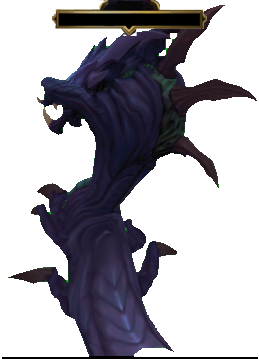

In [91]:
im_obj

In [87]:
def get_obj_bbox_from_cpos_size(cpos, size):
    return cpos[0] - size[0]/2, cpos[1] - size[1]/2, cpos[0] + size[0]/2, cpos[1] + size[1]/2

def get_yolo_bbox_cpos_size(ln):
    yolo_vals = np.array(ln.split(' ')).astype(np.float)
    ob_class = yolo_vals[0]
    cpos, ob_size = ((yolo_vals[1],yolo_vals[2]), 
                                (yolo_vals[3], yolo_vals[4]))
    bbox = get_obj_bbox_from_cpos_size(cpos, ob_size)
    return ob_class, cpos, ob_size, bbox
def get_cpos(pos, size):
    return (pos[0] + size[0]/2), (pos[1] + size[1]/2)

In [88]:
labels_err_crops_bbox = get_files_in_dir_as_list(path_output_labels, 'txt')
labels_hb = get_files_in_dir_as_list(path_output_labels_hb_class, 'txt')

In [98]:
lbls_corr_path = output_path_prefix + 'lbls_hb_and_crop_corrected/'
os.makedirs(lbls_corr_path, exist_ok=True)

for i in tqdm(range(len(labels_err_crops_bbox))):
    # Read lines
    lbls_err_lines = open(labels_err_crops_bbox[i]).readlines()
    lbls_hb_lines = open(labels_hb[i]).readlines()
    yolo_lbls = ''
    file_nm = labels_err_crops_bbox[i].split('/')[-1]
    for j in range(len(lbls_err_lines)):
        ob_class, crop_cpos, crop_size, crop_bbox = get_yolo_bbox_cpos_size(lbls_err_lines[j])
        _, hb_cpos, hb_size, hb_bbox = get_yolo_bbox_cpos_size(lbls_hb_lines[j])
        
        # Get bbox
        tl = min(hb_bbox[0], crop_bbox[0]), min(hb_bbox[1], crop_bbox[1])
        br = max(hb_bbox[2], crop_bbox[2]), max(hb_bbox[3], crop_bbox[3])
        corr_size = br[0] - tl[0], br[1] - tl[1]
        
        # Get cpos and size
        corr_cpos = get_cpos(tl, corr_size)
        yolo_lbls += create_yolo_label_str(corr_cpos, corr_size, int(ob_class), (1,1))
        
    save_file_nm = lbls_corr_path+file_nm
    with open(save_file_nm, 'w+') as sv:
        sv.write(yolo_lbls)
        #ln_lbls_err = np.array(lbls_err_lines[j].split(' ')).astype(np.float)
        #crop_cpos, crop_size = ((ln_lbls_err[1],ln_lbls_err[2]), 
        #                        (ln_lbls_err[3], ln_lbls_err[4]))
        #crop_bbox = get_obj_bbox_from_cpos_size(crop_cpos, crop_size)    

In [93]:
corr_cpos, corr_size

((0.5953125, 0.26342592592592595), (0.15625, 0.39166666666666666))

In [94]:
lbls_err_lines[j]

'1 0.5953125 0.2935185185185185 0.13958333333333334 0.3314814814814815\n'

In [95]:
labels_err_crops_bbox[i].split('/')[-1]

'lol_0.txt'

In [97]:
lbls_err_lines

['1 0.5953125 0.2935185185185185 0.13958333333333334 0.3314814814814815\n',
 '11 0.8859375 0.4064814814814815 0.11770833333333333 0.20925925925925926\n',
 '19 0.6197916666666666 0.4305555555555556 0.05625 0.07314814814814814\n',
 '17 0.2921875 0.05462962962962963 0.0484375 0.06111111111111111\n',
 '3 0.12135416666666667 0.7222222222222222 0.04635416666666667 0.05092592592592592\n',
 '3 0.978125 0.5685185185185185 0.034895833333333334 0.05277777777777778\n',
 '2 0.56875 0.7416666666666667 0.04583333333333333 0.08425925925925926\n',
 '3 0.41875 0.9601851851851851 0.050520833333333334 0.06481481481481481\n',
 '3 0.7260416666666667 0.5305555555555556 0.052083333333333336 0.0962962962962963\n',
 '2 0.7526041666666666 0.05092592592592592 0.03958333333333333 0.08148148148148149\n',
 '6 0.5796875 0.18703703703703703 0.1546875 0.08981481481481482\n',
 '3 0.48854166666666665 0.7564814814814815 0.05416666666666667 0.09351851851851851\n',
 '2 0.6177083333333333 0.8111111111111111 0.047916666666666